In [1]:
import numpy as np
from tqdm import tqdm
import QuantLib as ql
import matplotlib.pyplot as plt
%matplotlib inline

gpu = False
if gpu:
    import sigkernel as ksig
else:
    import sigkernel_cpu as ksig

from utils.transformations import *

# Setup parameters and kernel choice

In [2]:
X_seed=10
Y_seed=1
initial_value = 1.0

num_permutations = 10000
n_levels = 4
n_samples = 100
sample_len = 60
dt = 1 / 252
percentile = 0.95
difference = True

# Generate Data

In [3]:
X = ksig.tests.gen_GBM_path(mu=0.1, sigma=0.2, dt=dt, n_paths=n_samples, seq_len=sample_len, seed=X_seed).astype(np.float32) * initial_value
log_X = np.log(X)
Y = ksig.tests.gen_GBM_path(0.1, 0.3, dt, n_samples, sample_len, seed=Y_seed).astype(np.float32) * initial_value
log_Y = np.log(Y)

In [4]:
# Y = ksig.tests.gen_Heston_path(mu=0.1, v0=0.04, kappa=0.8, theta=0.04, sigma=0.5, rho=-0.5,
#                                dt=dt, n_paths=n_samples, seq_len=sample_len, seed=X_seed).astype(np.float32) * initial_value
# log_Y = np.log(Y)
# Y.shape

In [5]:
Y = ksig.tests.gen_OU_path(kappa=1.0, theta=1.0, sigma=0.2,
                               dt=dt, n_paths=n_samples, seq_len=sample_len, seed=X_seed).astype(np.float32) * initial_value
log_Y = np.log(Y)
Y.shape

(100, 60, 1)

In [6]:
X = lead_lag_transformation(X)
Y = lead_lag_transformation(Y)
X.shape, Y.shape

((100, 119, 2), (100, 119, 2))

(0.6311562389135361, 1.4698840647935867)

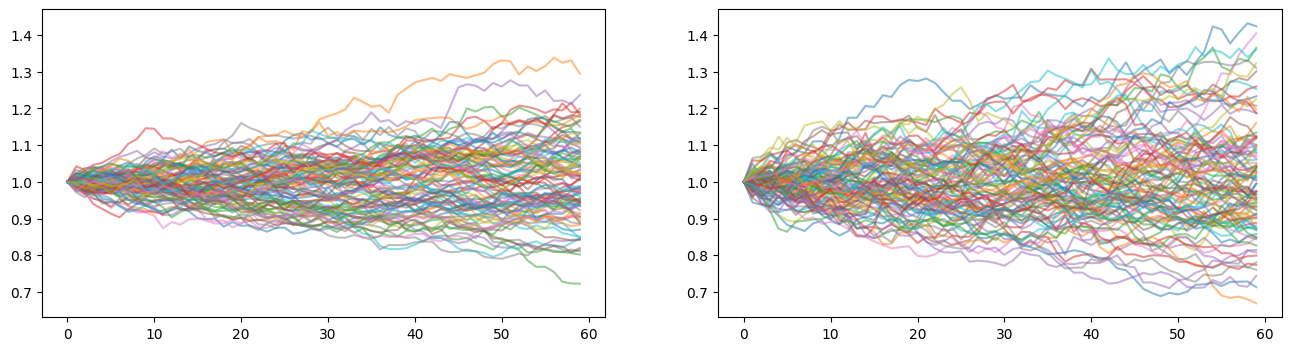

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
ax[0].plot(X.squeeze().T, alpha=0.5);
ax[1].plot(Y.squeeze().T, alpha=0.5);
ylim = min(ax[0].get_ylim()[0], ax[1].get_ylim()[0]), max(ax[0].get_ylim()[1], ax[1].get_ylim()[1]);
ax[0].set_ylim(ylim)
ax[1].set_ylim(ylim)

(-0.4395752549171448, 0.3969273567199707)

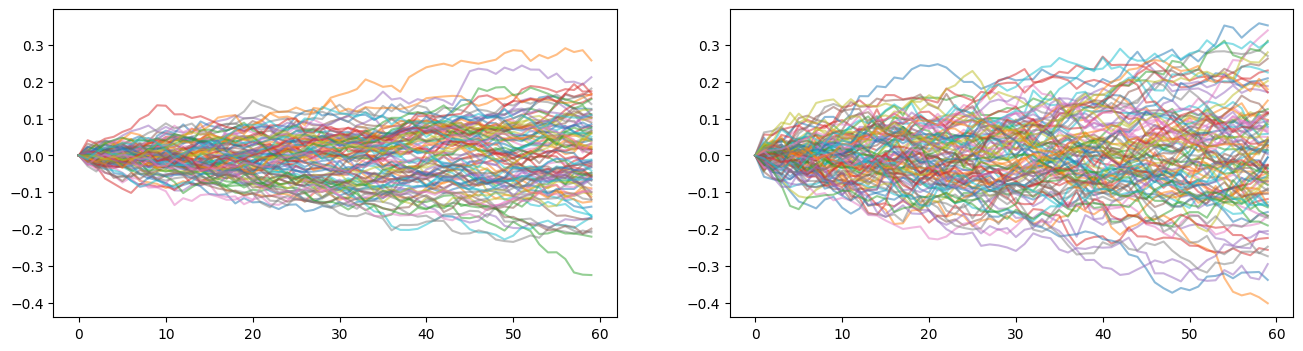

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
ax[0].plot(log_X.squeeze().T, alpha=0.5);
ax[1].plot(log_Y.squeeze().T, alpha=0.5);
ylim = min(ax[0].get_ylim()[0], ax[1].get_ylim()[0]), max(ax[0].get_ylim()[1], ax[1].get_ylim()[1]);
ax[0].set_ylim(ylim)
ax[1].set_ylim(ylim)

In [6]:
print(log_X.shape, log_Y.shape)
print(f'Mean: {np.mean(log_X)} / {np.mean(log_Y)}')
print(f'Variance: {np.var(log_X)} / {np.var(log_Y)}')

(100, 60, 1) (100, 60, 1)
Mean: -0.0046904925256967545 / -0.00110357697121799
Variance: 0.005307486280798912 / 0.010770384222269058


# MMD Two Sample Test

### Permutation Test

In [8]:
static_kernel = ksig.static.kernels.LinearKernel()
# static_kernel = ksig.static.kernels.RBFKernel(lengthscale=0.5)
# static_kernel = ksig.static.kernels.PolynomialKernel(degree=1)

In [14]:
idx = np.full((sample_len), False)
idx[0] = True
idx[-1] = True
X[:,idx,:].shape

(100, 2, 1)

Mean of permutation statistics: -6.352343034997898e-06


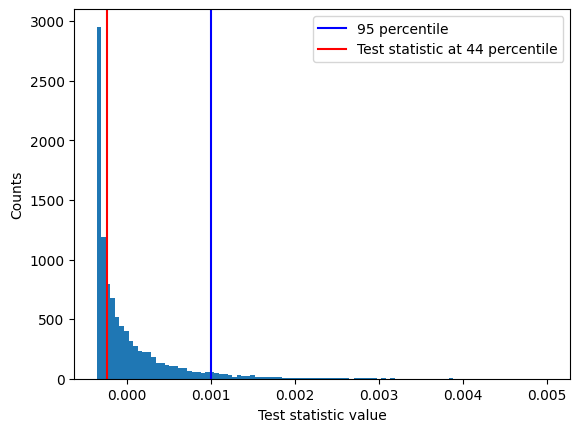

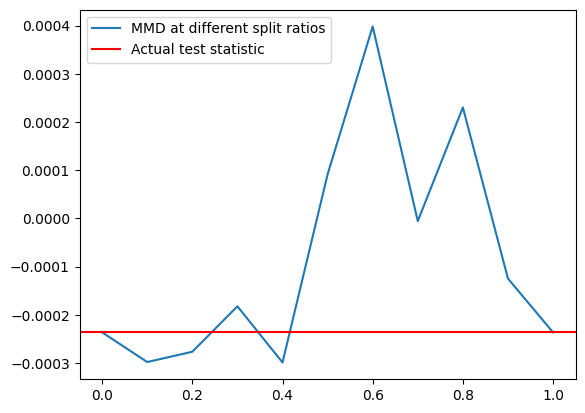

In [15]:
mmd_XY, null_mmd = ksig.tests.sig_kernel_test(X[:,idx,:], Y[:,idx,:], n_levels=n_levels, static_kernel=static_kernel, num_permutations=num_permutations, percentile=percentile)
print(f'Mean of permutation statistics: {np.mean(null_mmd)}')

Mean of permutation statistics: -2.0993268587927716e-07


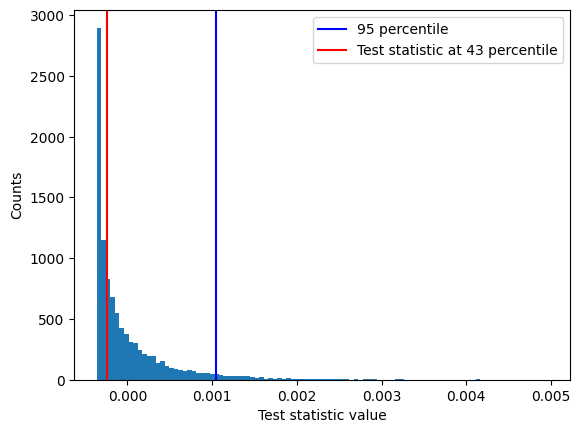

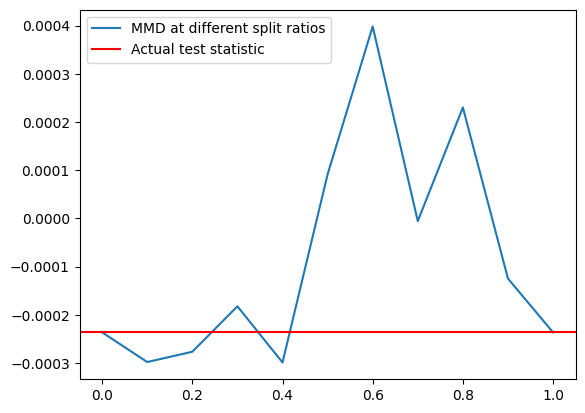

In [9]:
mmd_XY, null_mmd = ksig.tests.sig_kernel_test(X, Y, n_levels=n_levels, static_kernel=static_kernel, num_permutations=num_permutations, percentile=percentile)
print(f'Mean of permutation statistics: {np.mean(null_mmd)}')

### Log of X and Y

Mean of permutation statistics: -5.689879676545395e-06


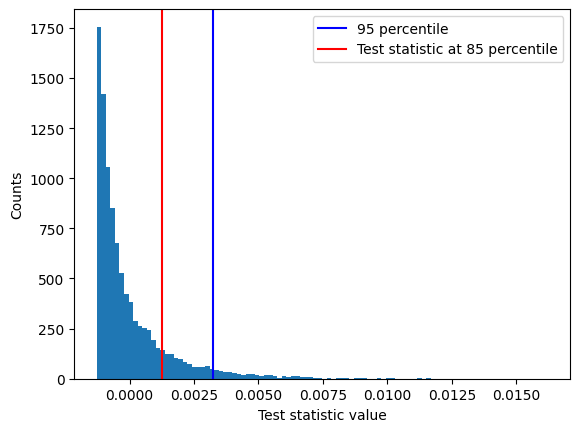

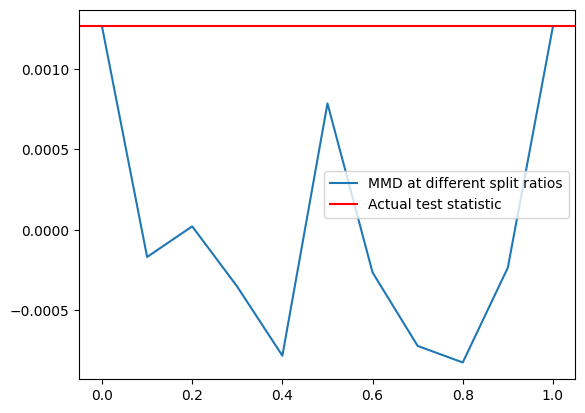

In [11]:
mmd_XY, null_mmd = ksig.tests.sig_kernel_test(np.log(X), np.log(Y), n_levels=n_levels, static_kernel=static_kernel, num_permutations=num_permutations, percentile=percentile)
print(f'Mean of permutation statistics: {np.mean(null_mmd)}')

# Multiple runs

In [9]:
# def savefig(path):
#     plt.savefig(path)
#     plt.clf()
#     plt.close()

# def plot_and_save_paths(path, X, Y):
#     _, ax = plt.subplots(1, 2, figsize=(16, 12))
#     ax[0].plot(X.squeeze().T, alpha=0.5);
#     ax[1].plot(Y.squeeze().T, alpha=0.5);
#     ylim = min(ax[0].get_ylim()[0], ax[1].get_ylim()[0]), max(ax[0].get_ylim()[1], ax[1].get_ylim()[1]);
#     ax[0].set_ylim(ylim)
#     ax[1].set_ylim(ylim)
#     savefig(path)

# def mmd_test_and_plot(p_suffix, param_name, param_value, n_samples, X, Y, n_levels, static_kernel, kernel_name, log=False):
#     log = '_log' if log else ''
#     mmd_XY, null_mmd = ksig.tests.sig_kernel_test(X, Y, n_levels=n_levels, static_kernel=static_kernel, num_permutations=num_permutations, stats_plot=False)
#     savefig(f'./figures/{param_name}/splits/{p_suffix}_{param_name}_{param_value}_ratio{log}_{kernel_name}_level_{n_levels}_{n_samples}_samples.png')
#     ksig.tests.plot_permutation_samples(null_mmd, mmd_XY)
#     savefig(f'./figures/{param_name}/{p_suffix}_{param_name}_{param_value}_quantile{log}_{kernel_name}_level_{n_levels}_{n_samples}_samples.png')

In [10]:
# # vary mu

# period = ['daily', 'daily', 'weekly', 'monthly']
# lens = [30, 60, 52, 12]
# samples = [200, 100, 100, 100]
# sub_sample = [False, False, True, True]
# period_dt = [252, 252, 52, 12]
# sub_size = 10
# upper_level_limit = 3
# kernel_name = ['linear', 'rbf']

# for i, t in enumerate(period_dt):
#     p_suffix = period[i]
#     dt = 1 / t
#     sample_len = lens[i]
#     n_samples = samples[i]
#     X = ksig.tests.gen_GBM_path(mu=0.1, sigma=0.2, dt=dt, n_paths=n_samples, seq_len=sample_len, seed=X_seed).astype(np.float32)
#     log_X = np.log(X)

#     for mu in [0.05, 0.1, 0.15, 0.2]:
#         Y = ksig.tests.gen_GBM_path(mu, 0.2, dt, n_samples, sample_len, seed=Y_seed).astype(np.float32)
#         log_Y = np.log(Y)
#         plot_and_save_paths(f'./figures/mu/path plots/{p_suffix}_mu_{mu}_paths_{n_samples}_samples.png', X, Y)
#         plot_and_save_paths(f'./figures/mu/path plots/{p_suffix}_mu_{mu}_paths_log_{n_samples}_samples.png', log_X, log_Y)

#         for j, static_kernel in enumerate([ksig.static.kernels.LinearKernel(), ksig.static.kernels.RBFKernel(lengthscale=0.2)]):

#             for n_levels in range(2, upper_level_limit+1):
#                 mmd_test_and_plot(p_suffix, 'mu', mu, n_samples, X, Y, n_levels, static_kernel, kernel_name[j])
#                 mmd_test_and_plot(p_suffix, 'mu', mu, n_samples, log_X, log_Y, n_levels, static_kernel, kernel_name[j], log=True)

#                 if sub_sample[i]:
#                     mmd_test_and_plot(p_suffix, 'mu', mu, sub_size, X[:sub_size], Y[:sub_size], n_levels, static_kernel, kernel_name[j])
#                     mmd_test_and_plot(p_suffix, 'mu', mu, sub_size, log_X[:sub_size], log_Y[:sub_size], n_levels, static_kernel, kernel_name[j], log=True)

In [ ]:
# # vary sigma

# for i, t in enumerate(period_dt):
#     p_suffix = period[i]
#     dt = 1 / t
#     sample_len = lens[i]
#     n_samples = samples[i]
#     X = ksig.tests.gen_GBM_path(mu=0.1, sigma=0.2, dt=dt, n_paths=n_samples, seq_len=sample_len, seed=X_seed).astype(np.float32)
#     log_X = np.log(X)

#     for sigma in [0.1, 0.2, 0.3, 0.4]:
#         Y = ksig.tests.gen_GBM_path(0.1, sigma, dt, n_samples, sample_len, seed=Y_seed).astype(np.float32)
#         log_Y = np.log(Y)
#         plot_and_save_paths(f'./figures/sigma/path plots/{p_suffix}_sigma_{sigma}_paths_{n_samples}_samples.png', X, Y)
#         plot_and_save_paths(f'./figures/sigma/path plots/{p_suffix}_sigma_{sigma}_paths_log_{n_samples}_samples.png', log_X, log_Y)

#         for j, static_kernel in enumerate([ksig.static.kernels.LinearKernel(), ksig.static.kernels.RBFKernel(lengthscale=0.2)]):

#             for n_levels in range(2, upper_level_limit+1):
#                 mmd_test_and_plot(p_suffix, 'sigma', sigma, n_samples, X, Y, n_levels, static_kernel, kernel_name[j])
#                 mmd_test_and_plot(p_suffix, 'sigma', sigma, n_samples, log_X, log_Y, n_levels, static_kernel, kernel_name[j], log=True)

#                 if sub_sample[i]:
#                     mmd_test_and_plot(p_suffix, 'sigma', sigma, sub_size, X[:sub_size], Y[:sub_size], n_levels, static_kernel, kernel_name[j])
#                     mmd_test_and_plot(p_suffix, 'sigma', sigma, sub_size, log_X[:sub_size], log_Y[:sub_size], n_levels, static_kernel, kernel_name[j], log=True)